# Instrumental Variables (IV) Analysis: Education and Income

## Introduction

**Instrumental Variables (IV)** is a statistical method used to estimate causal relationships when controlled experiments are not feasible and there is a problem of **endogeneity** (e.g., omitted variable bias, reverse causality).

### The Scenario: Does Education Cause Higher Income?

We want to know the *causal* effect of **Education** (years of schooling) on **Income**.

**The Problem (Endogeneity):**
We cannot simply regress Income on Education because of a confounding variable: **Ability** (or Talent/Intelligence). 
- People with high **Ability** are more likely to get more **Education**.
- People with high **Ability** are also likely to earn a higher **Income**, regardless of their education.

If we ignore **Ability** (which is often unobserved/latent), our OLS regression will **overestimate** the return to education. It will attribute the income boost from Ability to Education.

### The Solution: Instrumental Variables

We need an **Instrument (Z)** that acts as a randomizer for Education. A valid instrument must satisfy two conditions:
1.  **Relevance**: The instrument must be correlated with the endogenous variable (Education). 
    -   *Example*: **Distance to the nearest college**. Living closer to a college makes it easier/cheaper to attend, so it increases Education.
2.  **Exclusion Restriction**: The instrument must NOT affect the outcome (Income) directly, only through the endogenous variable (Education).
    -   *Example*: Living closer to a college doesn't magically make you richer, except by helping you get a degree.

In this notebook, we will:
1.  Generate synthetic data with a known causal effect.
2.  Demonstrate the bias of a standard OLS regression.
3.  Use **Two-Stage Least Squares (2SLS)** with IV to recover the true causal effect.

### 1. Setup and Library Installation
We will use `linearmodels` for IV estimation, along with standard data science libraries.

In [1]:
# Install linearmodels if not already installed
%pip install linearmodels pandas seaborn matplotlib numpy

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   --------------------------- ------------ 1.0/1.5 MB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels.iv import IV2SLS

# Set random seed for reproducibility
np.random.seed(42)

### 2. Data Generation

We will simulate a dataset for 1,000 individuals.

**Variables:**
-   `Ability` (Unobserved Confounder): Randomly distributed.
-   `Distance` (Instrument): Distance to nearest college. Randomly distributed.
-   `Education` (Endogenous Treatment): Positively affected by `Ability`, Negatively affected by `Distance`.
-   `Income` (Outcome): Positively affected by `Education` (True Causal Effect = **2.5**) and `Ability`.

**True Model:**
$$ Income = 10 + 2.5 \times Education + 1.5 \times Ability + Noise $$

In [3]:
# Number of observations
n = 1000

# 1. Confounder: Ability (Unobserved in real life)
# Higher values = higher innate ability
ability = np.random.normal(0, 1, n)

# 2. Instrument: Distance to nearest college (Observed)
# Randomly distributed, affects education cost
distance = np.random.normal(0, 1, n)

# 3. Endogenous Variable: Education (Years of schooling)
# Affected by Ability (+) and Distance (-)
# People with high ability get more education.
# People living far away get less education.
education = 12 + 0.8 * ability - 0.5 * distance + np.random.normal(0, 0.5, n)

# 4. Outcome Variable: Income (Hourly wage)
# Affected by Education (+) and Ability (+)
# TRUE CAUSAL EFFECT of Education = 2.5
income = 10 + 2.5 * education + 1.5 * ability + np.random.normal(0, 1, n)

# Create DataFrame
df = pd.DataFrame({
    'Income': income,
    'Education': education,
    'Distance': distance,
    'Ability': ability # We typically wouldn't see this!
})

print("Dataset Preview:")
print(df.head())

Dataset Preview:
      Income  Education  Distance   Ability
0  37.237525  11.360104  1.399355  0.496714
1  37.319249  11.354812  0.924634 -0.138264
2  40.788241  12.092126  0.059630  0.647689
3  47.642011  13.387912 -0.646937  1.523030
4  36.497219  10.516758  0.698223 -0.234153


### 3. Visualizing the Relationships

Let's look at the correlation matrix. We expect:
-   `Education` and `Income` to be highly correlated.
-   `Ability` to be correlated with both (the source of bias).
-   `Distance` to be correlated with `Education` (Relevance) but NOT with `Ability` (Exogeneity).

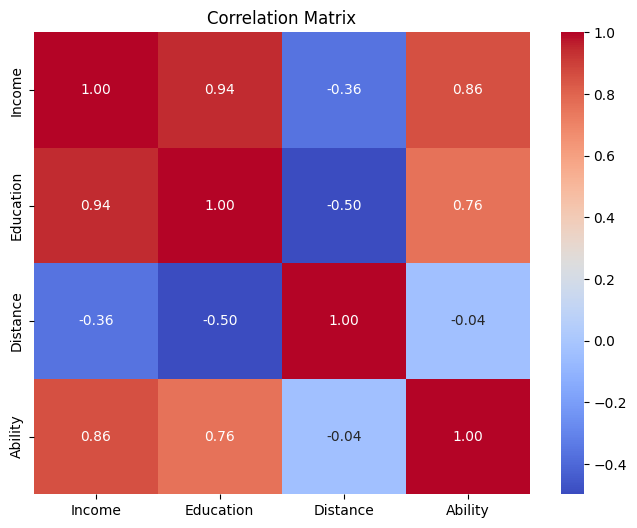

In [4]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### 4. Naive OLS Regression

Let's run a standard Ordinary Least Squares (OLS) regression of `Income` on `Education`. 

$$ Income = \beta_0 + \beta_1 Education + \epsilon $$

**Hypothesis:** Since `Ability` is omitted and positively correlates with both variables, $\beta_1$ should be **biased upwards** (greater than the true value of 2.5).

In [5]:
# Add constant for intercept
X_ols = sm.add_constant(df['Education'])
y = df['Income']

# Fit OLS model
ols_model = sm.OLS(y, X_ols).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     7789.
Date:                Wed, 03 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:15:57   Log-Likelihood:                -1733.5
No. Observations:                1000   AIC:                             3471.
Df Residuals:                     998   BIC:                             3481.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6566      0.485     -5.478      0.0

> **Observation:** The OLS coefficient for Education is likely significantly **higher than 2.5**. This confirms the omitted variable bias. The model mistakenly attributes the income gains from Ability to Education.

### 5. Instrumental Variables (IV) Estimation (2SLS)

Now we use **Two-Stage Least Squares (2SLS)** to correct for the bias.

**Stage 1:** Regress `Education` on the Instrument `Distance`.
$$ Education = \alpha_0 + \alpha_1 Distance + \nu $$
This isolates the variation in Education that is *caused* by Distance (which is random/exogenous) and removes the variation caused by Ability.

**Stage 2:** Regress `Income` on the *Predicted Education* from Stage 1.
$$ Income = \beta_0 + \beta_{IV} \widehat{Education} + \epsilon $$

We use the `linearmodels` library to do this in one step.

In [6]:
# Define variables for IV2SLS
# Dependent: Income
# Exogenous: Constant (1)
# Endogenous: Education
# Instruments: Distance

df['const'] = 1 # Add constant column

# IV2SLS(dependent, exog, endog, instruments)
iv_model = IV2SLS(dependent=df['Income'],
                  exog=df['const'],
                  endog=df['Education'],
                  instruments=df['Distance']).fit()

print(iv_model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                 Income   R-squared:                      0.8368
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8366
No. Observations:                1000   F-statistic:                    815.69
Date:                Wed, Dec 03 2025   P-value (F-stat)                0.0000
Time:                        14:15:57   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          7.4271     1.1412     6.5081     0.0000      5.1904      9.6638
Education      2.7156     0.0951     28.560     0.00

### 6. Comparison and Conclusion

Let's compare the estimated coefficients.

True Causal Effect: 2.5
OLS Estimate (Biased): 3.5571
IV Estimate (Consistent): 2.7156


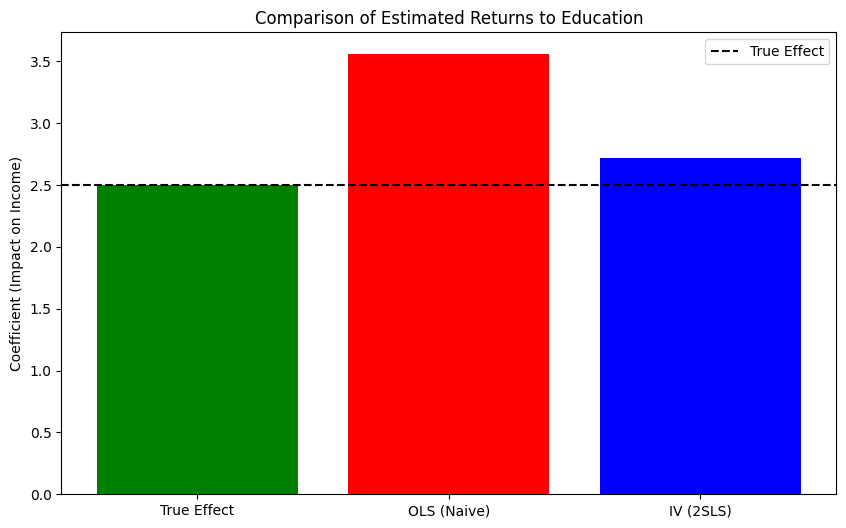

In [7]:
true_effect = 2.5
ols_effect = ols_model.params['Education']
iv_effect = iv_model.params['Education']

print(f"True Causal Effect: {true_effect}")
print(f"OLS Estimate (Biased): {ols_effect:.4f}")
print(f"IV Estimate (Consistent): {iv_effect:.4f}")

# Visualization of the bias correction
plt.figure(figsize=(10, 6))
plt.bar(['True Effect', 'OLS (Naive)', 'IV (2SLS)'], 
        [true_effect, ols_effect, iv_effect], 
        color=['green', 'red', 'blue'])
plt.axhline(y=true_effect, color='black', linestyle='--', label='True Effect')
plt.title("Comparison of Estimated Returns to Education")
plt.ylabel("Coefficient (Impact on Income)")
plt.legend()
plt.show()

## Conclusion

1.  **OLS Bias**: The Naive OLS regression significantly **overestimated** the effect of education on income. This is because it couldn't distinguish between the effect of schooling and the effect of innate ability (the confounder).
2.  **IV Correction**: The Instrumental Variable (Distance) successfully isolated the variation in education that was *uncorrelated* with ability. 
3.  **Result**: The IV estimate is much closer to the **True Causal Effect (2.5)**, demonstrating the power of this technique in causal inference.

**Key Takeaway**: When you suspect endogeneity (e.g., feedback loops, omitted variables), standard regression fails. Finding a clever instrument—like "distance to school" or "rainfall" for agricultural output—allows you to uncover the true causal link.